# Geneva 0.1.37 Feature Engineering demo

Here we demonstrate 4 backfill jobs specified by UDFs

- file size (scalar)
- dimensions (return struct) 
- caption (uses gpu/model to extract description using the blip library \[transformers (4.51), accelerate\])
- embedding (uses gpu  packages to generate captions on a small set of images)

In [1]:
# specify a path for data to be stored.  Can be on the local filesystem or object store
from datetime import datetime
now = datetime.now()

# different datetime each time.
GENEVA_VERSION="0.1.37"
GENEVA_DB_PATH=f"gs://jon-geneva-demo/vertexai-workbench-{GENEVA_VERSION}-{now.strftime('%y%m%d-%H%M%S')}"
# hard coded to 2k images
# GENEVA_DB_PATH="gs://jon-geneva-demo/vertexai-workbench-0.1.37-250815-125316" 
NUM_IMAGES=500
GENEVA_DB_PATH

'gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038'

In [2]:
!python --version
!pwd
!pip install --upgrade datasets pillow

Python 3.10.16
/home/jupyter/notebooks
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geneva 0.1.37 requires fsspec>=2025.5.1, but you have fsspec 2025.3.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
pip uninstall geneva -y

Found existing installation: geneva 0.1.37
Uninstalling geneva-0.1.37:
  Successfully uninstalled geneva-0.1.37
Note: you may need to restart the kernel to use updated packages.


In [4]:
%load_ext autoreload
%autoreload 2

## dev mode
#import sys
# sys.path.append("../proj/geneva/src")

## local install
# ! uv pip install -e ../proj/geneva

## install from pypi repos
! uv pip install geneva=={GENEVA_VERSION}

Using Python 3.10.16 environment at: /opt/conda
⠹ dill==0.3.8                                                                   Resolved 52 packages in 417ms
Uninstalled 1 package in 6ms
░░░░░░░░░░░░░░░░░░░░ [0/2] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 2 packages in 57ms                                
 - fsspec==2025.3.0
 + fsspec==2025.7.0
 + geneva==0.1.37


In [5]:
# dump more logging info
import logging
import sys
# logging.basicConfig(level=logging.DEBUG, stream=sys.stderr, force=True)

# enable timestamped logging
logging.basicConfig(
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    # level=logging.DEBUG,
    level=logging.INFO,
    # level=logging.WARN,
    stream=sys.stderr,
    force=True
)

# geneva version should be >= 0.1.23
import geneva
import pyarrow as pa
import lance
import lancedb
import datasets

print(f"geneva {geneva.__version__} lancedb {lancedb.__version__}")
print(f"datasets {datasets.__version__}")

geneva 0.1.37 lancedb 0.24.3
datasets 4.0.0


In [6]:
!pip install torch

/opt/conda/lib/python3.10/site-packages/lancedb/__init__.py:238: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [7]:
# verify that this machine has GPU
import torch

has_gpu = torch.cuda.is_available()

print("CUDA available:", has_gpu)
if has_gpu:
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU memory (MB):", torch.cuda.get_device_properties(0).total_memory / 1024**2)

CUDA available: False


# Load images
This code loads images from the oxfords pets dataset.  Cute cats and dog.

In [8]:
# Convert a hugging face dataset to lance dataset is easy
import pyarrow as pa
from datasets import load_dataset
# import lance
import shutil
import io
from geneva.tqdm import tqdm 

shutil.rmtree(GENEVA_DB_PATH, ignore_errors=True)

def load_images(frag_size:int = 25):
    dataset = load_dataset("timm/oxford-iiit-pet", split=f"train[:{NUM_IMAGES}]")
    batch = []
    for row in tqdm(dataset):
        buf = io.BytesIO()
        row["image"].save(buf, format="png")
        batch.append({"image": buf.getvalue(), "label": row["label"], "image_id":row["image_id"], "label_cat_dog":row["label_cat_dog"]})
        if len(batch) >= frag_size:
            yield pa.RecordBatch.from_pylist(batch)
            batch = []

    if len(batch):
        yield pa.RecordBatch.from_pylist(batch)
db = geneva.connect(GENEVA_DB_PATH)

tbl.list_versions()

tbl = db.open_table("images")

tbl.restore(80) # before any column additions
tbl.to_pandas()

from yarl import URL
base = URL(GENEVA_DB_PATH) 
ckp = str(base / "ckp")
hist = str(base / "geneva_jobs.lance")
ckp, hist

import fsspec
from fsspec.core import url_to_fs

def ls(uri:str) :
    store, path = url_to_fs(uri)
    return store.ls(path)

def rmr(uri:str) : 
    store, path = url_to_fs(uri)
    store.rm(path, recursive=True)

print(f"checkpoint dir has {len(ls(ckp))} files.  deleting..")
rmr(ckp)


print(f"checkpoint dir has {len(ls(hist))} files.  deleting..")m
rmr(hist)

In [9]:
first = True
for batch in load_images():
    if first:        
        tbl = db.create_table("images", batch, mode="overwrite")
        first = False
    else:
        tbl.add(batch)
    
db.table_names()

  0%|          | 0/500 [00:00<?, ?it/s]

[2025-08-19T20:00:58Z WARN  lance::dataset::write::insert] No existing dataset at gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/images.lance?, it will be created


['images']

# Show images
There is now an image table, with images and some labeling metadata

In [10]:
df = tbl.to_pandas()
df

,image,label,image_id,label_cat_dog
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1
...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1


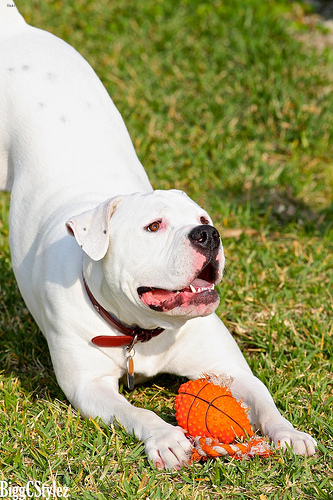

In [11]:
import io
from PIL import Image

all_images = []
for b in df['image']:
    image_stream = io.BytesIO(b)
    image = Image.open(image_stream)
    all_images.append(image)

image = all_images[1]
image

# Setup for distributed execution on gke kuberay k8s cluster
This pulls in all the dependencies for the models and cloud access.  It then configure the exectuion environment, and enters the context for our jobs to run in


### Pull all dependencies in

In [12]:
# Ray and k8s dependencies
!pip install ray==2.44.1
!pip install kubernetes
!pip install google-cloud google-cloud-storage
!pip install ray[client]

/opt/conda/lib/python3.10/site-packages/lancedb/__init__.py:238: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [13]:
# dependencies for blip captioning
!pip install transformers==4.51 torch accelerate


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [14]:
# dependencies for embeddings  
# TODO - reloading packages is expensive and seems to be unreliable.
!pip install open-clip-torch 
!pip install scikit-learn
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Configure the cluster

In [15]:
# Names for k8s pod and the k8s namespace to deploy onb
k8s_name = "jon-demo"
k8s_namespace = "geneva"

In [16]:
import pyarrow as pa
import pyarrow.compute as pc
import geneva
from geneva import udf

In [17]:
import logging

import ray

from geneva.config import override_config
from geneva.config.loader import from_kv
from geneva.runners.ray.raycluster import RayCluster, _HeadGroupSpec, _WorkerGroupSpec
from geneva.runners.ray._mgr import ray_cluster
try:
    ray.shutdown()
except:
    pass

In [18]:
from yarl import URL
# override_config(from_kv({"uploader.upload_dir": images_path + "./zips"}))
override_config(from_kv({"uploader.upload_dir": str(URL(GENEVA_DB_PATH) / "zips")}))

def demo_raycluster():
    raycluster =  ray_cluster(
        name= k8s_name,
        namespace=k8s_namespace,
        use_portforwarding=True,
        # project="lancedb-dev-us-central1",
        head_group=_HeadGroupSpec(
            service_account="geneva-integ-test",
            num_cpus=1,
            memory="4G"
        ),
        worker_groups=[
            _WorkerGroupSpec(
                name="cpu",
                num_cpus=4,
                memory="12G",
                service_account="geneva-integ-test",
                # replicas=2, # Start the cluster with this many nodes, subject to autoscale down. Hopefully faster startup. (default 0)                  
                min_replicas=2, # Min workers to auto-scale down to. (default 0)
                # maxReplicas=8, # Max workers to auto-scale up to. (default infinite)
                # idleTimeoutSeconds = 60 # idle time before considered for termination (default 60s)
            ),
            _WorkerGroupSpec(
                name="gpu",
                num_cpus=4,
                memory="12G",
                num_gpus=1,
                service_account="geneva-integ-test",
                # replicas=2, # Start the cluster with this many nodes, subject to autoscale down. Hopefully faster startup. (default 0)                  
                min_replicas=2, # Min workers to auto-scale down to. (default 0)
                # maxReplicas=8, # Max workers to auto-scale up to. (default infinite)
                # idleTimeoutSeconds = 60 # idle time before considered for termination (default 60)
            ),
        ],
    )
    return raycluster

raycluster = demo_raycluster()

In [19]:
! gcloud iam service-accounts list --filter="displayName:Ray Runner GSA"

/opt/conda/lib/python3.10/site-packages/lancedb/__init__.py:238: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


DISPLAY NAME    EMAIL                                                       DISABLED
ray runner gsa  ray-runner@lancedb-dev-us-central1.iam.gserviceaccount.com  False


In [20]:
# Get the latest gk cloud auth plugin so we can generate credentials and config needed to connect to gke.
! sudo apt-get update
! sudo apt-get install -y google-cloud-cli-gke-gcloud-auth-plugin

Hit:1 https://packages.cloud.google.com/apt gcsfuse-bullseye InRelease
Hit:2 https://download.docker.com/linux/debian bullseye InRelease   
Get:3 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease [1477 B]
Hit:4 https://deb.debian.org/debian bullseye InRelease                         
Hit:5 https://packages.cloud.google.com/apt google-compute-engine-bullseye-stable InRelease
Get:6 https://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Hit:7 https://deb.debian.org/debian bullseye-updates InRelease
Hit:8 https://packages.cloud.google.com/apt cloud-sdk-bullseye InRelease
Ign:9 https://deb.debian.org/debian bullseye-backports InRelease
Err:10 https://deb.debian.org/debian bullseye-backports Release
  404  Not Found [IP: 151.101.2.132 443]
Hit:11 https://packages.cloud.google.com/apt google-fast-socket InRelease
Get:12 https://deb.debian.org/debian-security bullseye-security/main amd64 Packages [391 kB]
Reading package lists... Done 
E: The reposi

In [21]:
# !kubectl auth can-i get pods --as=system:serviceaccount:geneva-integ:ray-runner
!gcloud container clusters get-credentials geneva-integ --zone us-central1 --project lancedb-dev-us-central1

Fetching cluster endpoint and auth data.
kubeconfig entry generated for geneva-integ.


# Start cluster

try:
    ray.shutdown()
except:
    pass

try:
    raycluster.__exit__(None, None, None)
except:
    pass


In [22]:
%%time
# This call can take >5mins to run.  This only needs to be re-done if new new modules are introduced into the environment.
raycluster = demo_raycluster()
raycluster.__enter__()

2025-08-19 20:02:25 INFO Starting Ray cluster
2025-08-19 20:02:28 INFO cluster status: {'desiredCPU': '9', 'desiredGPU': '1', 'desiredMemory': '28G', 'desiredTPU': '0', 'desiredWorkerReplicas': 4, 'endpoints': {'client': '10001', 'dashboard': '8265', 'gsc-server': '6379', 'metrics': '8080'}, 'head': {'podIP': '10.60.5.30', 'podName': 'jon-demo-head-hmtk7', 'serviceIP': '10.60.5.30', 'serviceName': 'jon-demo-head-svc'}, 'lastUpdateTime': '2025-08-19T20:02:28Z', 'maxWorkerReplicas': 200, 'minWorkerReplicas': 4, 'observedGeneration': 1}
2025-08-19 20:02:28 INFO cluster status: {'desiredCPU': '9', 'desiredGPU': '1', 'desiredMemory': '28G', 'desiredTPU': '0', 'desiredWorkerReplicas': 4, 'endpoints': {'client': '10001', 'dashboard': '8265', 'gsc-server': '6379', 'metrics': '8080'}, 'head': {'podIP': '10.60.5.30', 'podName': 'jon-demo-head-hmtk7', 'serviceIP': '10.60.5.30', 'serviceName': 'jon-demo-head-svc'}, 'lastUpdateTime': '2025-08-19T20:02:28Z', 'maxWorkerReplicas': 200, 'minWorkerRepli

0it [00:00, ?it/s]

  0%|          | 0.00/58.9M [00:00<?, ?B/s]

2025-08-19 20:02:28 INFO packaging /opt/conda/lib/python3.10/site-packages


0it [00:00, ?it/s]

  0%|          | 0.00/6.93G [00:00<?, ?B/s]

2025-08-19 20:02:38 INFO found paths to package: [PosixPath('/home/jupyter/notebooks'), PosixPath('/opt/conda/lib/python3.10/site-packages')]
2025-08-19 20:02:38 INFO packaging /home/jupyter/notebooks


0it [00:00, ?it/s]

  0%|          | 0.00/58.9M [00:00<?, ?B/s]

2025-08-19 20:02:38 INFO Zipping /home/jupyter/notebooks to /var/tmp/tmpzgasuutl/15fce9dae7a2efe1ced333036800face8095eecc10fa46ad3dbc702afa4ce0fe.zip with 51 files
2025-08-19 20:02:38 INFO Zipping workspace /home/jupyter/notebooks to /var/tmp/tmpzgasuutl/15fce9dae7a2efe1ced333036800face8095eecc10fa46ad3dbc702afa4ce0fe.zip
2025-08-19 20:02:40 INFO packaging /opt/conda/lib/python3.10/site-packages


0it [00:00, ?it/s]

  0%|          | 0.00/6.93G [00:00<?, ?B/s]

2025-08-19 20:02:43 INFO 27 chunks to zip
2025-08-19 20:02:43 INFO 27 filtered chunks to zip:
2025-08-19 20:05:37 INFO Uploading 1 zip files: [PosixPath('/var/tmp/tmpzgasuutl/15fce9dae7a2efe1ced333036800face8095eecc10fa46ad3dbc702afa4ce0fe.zip')]
2025-08-19 20:05:37 INFO Uploading 27 zip files: [PosixPath('/var/tmp/tmpzgasuutl/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part00.zip'), PosixPath('/var/tmp/tmpzgasuutl/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part01.zip'), PosixPath('/var/tmp/tmpzgasuutl/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part02.zip'), PosixPath('/var/tmp/tmpzgasuutl/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part03.zip'), PosixPath('/var/tmp/tmpzgasuutl/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part04.zip'), PosixPath('/var/tmp/tmpzgasuutl/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part05.zip'), PosixPath('/var/tmp/tmpzgasuutl/03a19

  0%|          | 0.00/3.67G [00:00<?, ?B/s]

2025-08-19 20:05:46 INFO Uploaded 3 zip path file sets to gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips: [['gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips/15fce9dae7a2efe1ced333036800face8095eecc10fa46ad3dbc702afa4ce0fe.zip'], ['gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part00.zip', 'gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part03.zip', 'gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part02.zip', 'gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part06.zip', 'gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/zips/03a19a8e33c571edc71fa21a9b61c9eedfe8fdcf3956f8d24dd85369c6277eda.part10.zip', 'gs://jo

CPU times: user 1min 28s, sys: 20.7 s, total: 1min 49s
Wall time: 3min 30s


Exception in thread Kubernetes port forward proxy: 10001:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/kubernetes/stream/ws_client.py", line 377, in _proxy
    opcode, frame = self.websocket.recv_data_frame(True)
  File "/opt/conda/lib/python3.10/site-packages/websocket/_core.py", line 437, in recv_data_frame
    frame = self.recv_frame()
  File "/opt/conda/lib/python3.10/site-packages/websocket/_core.py", line 478, in recv_frame
    return self.frame_buffer.recv_frame()
  File "/opt/conda/lib/python3.10/site-packages/websocket/_abnf.py", line 363, in recv_frame
    self.recv_header()
  File "/opt/conda/lib/python3.10/

(autoscaler +2m19s) Resized to 20 CPUs, 2 GPUs.
(autoscaler +2m39s) Removing 1 nodes of type cpu (idle).
(autoscaler +2m50s) Resized to 16 CPUs, 2 GPUs.


(pid=294, ip=10.60.4.6) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in ColPaliEmbeddings has conflict with protected namespace "model_".
(pid=294, ip=10.60.4.6) 
(pid=294, ip=10.60.4.6) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(pid=294, ip=10.60.4.6)   warnings.warn(
(pid=294, ip=10.60.4.6) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in SigLipEmbeddings has conflict with protected namespace "model_".
(pid=294, ip=10.60.4.6) 
(pid=294, ip=10.60.4.6) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(pid=294, ip=10.60.4.6)   warnings.warn(
(pid=293, ip=10.60.4.6) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in ColPaliEmbeddings has conflict with protected namespace "model_".
(p

(autoscaler +8m12s) Adding 6 node(s) of type gpu.


(pid=1936, ip=10.60.8.5) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in ColPaliEmbeddings has conflict with protected namespace "model_".
(pid=1936, ip=10.60.8.5) 
(pid=1936, ip=10.60.8.5) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(pid=1936, ip=10.60.8.5)   warnings.warn(
(pid=1936, ip=10.60.8.5) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in SigLipEmbeddings has conflict with protected namespace "model_".
(pid=1936, ip=10.60.8.5) 
(pid=1936, ip=10.60.8.5) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(pid=1936, ip=10.60.8.5)   warnings.warn(
(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x783f171ef700>, map_task=BackfillUDFTask(udfs={'caption_blip_v2': UDF(func=<__main__.GenCapt

(autoscaler +11m16s) Adding 2 node(s) of type gpu.


(pid=11036, ip=10.60.4.6) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in ColPaliEmbeddings has conflict with protected namespace "model_".
(pid=11036, ip=10.60.4.6) 
(pid=11036, ip=10.60.4.6) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(pid=11036, ip=10.60.4.6)   warnings.warn(
(pid=11036, ip=10.60.4.6) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in SigLipEmbeddings has conflict with protected namespace "model_".
(pid=11036, ip=10.60.4.6) 
(pid=11036, ip=10.60.4.6) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(pid=11036, ip=10.60.4.6)   warnings.warn(
(pid=4975, ip=10.60.4.4) /home/ray/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in ColPaliEmbeddings has conflict with protected names

# Simple Scalar backfill jobs

In [23]:
from geneva import udf

@udf
def file_size(image:bytes) -> int:
    return len(image)

@udf(data_type=pa.struct([pa.field("width", pa.int32()), pa.field("height", pa.int32())]))
def dimensions(image:bytes) -> (int, int):
    image_stream = io.BytesIO(image)
    img = Image.open(image_stream)
    return img.size

In [24]:
tbl.to_pandas()

,image,label,image_id,label_cat_dog
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1
...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1


In [25]:
try:
    tbl.drop_columns(["file_size" , "dimensions"])
except:
    pass

tbl.add_columns({"file_size":file_size, "dimensions":dimensions})

tbl.to_pandas()

2025-08-19 20:05:56 INFO Adding column: udf={'file_size': UDF(func=<function file_size at 0x7f152840be20>, name='file_size', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(int64), version='6918aa2663947a6399ad87e52b3c9b58', checkpoint_key='file_size:6918aa2663947a6399ad87e52b3c9b58', field_metadata={})}
2025-08-19 20:05:57 INFO Adding column: udf={'dimensions': UDF(func=<function dimensions at 0x7f1512cbb880>, name='dimensions', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=StructType(struct<width: int32, height: int32>), version='e64112b36c08fb6bde12cdf7784c0c5d', checkpoint_key='dimensions:e64112b36c08fb6bde12cdf7784c0c5d', field_metadata={})}


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,NaN,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,NaN,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,NaN,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,NaN,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,NaN,None
...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,NaN,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,NaN,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,NaN,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,NaN,None


In [26]:
%%time 
# This usually takes 2 minutes to start showing workers ready progress bar an then 90s more for work to start.
tbl.backfill("file_size", batch_size=10)
tbl.to_pandas()

Cluster nodes provisioned: |           0 [00:00]

Workers scheduled: |           0 [00:00]

[2025-08-19T20:05:59Z WARN  lance::dataset::write::insert] No existing dataset at gs://jon-geneva-demo/vertexai-workbench-0.1.37-250819-200038/geneva_jobs.lance?, it will be created


Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - file_size] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - file_size] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - file_size] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 13.8 s, sys: 2.28 s, total: 16.1 s
Wall time: 5min 35s


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,None
...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,None


tbl.checkout_latest()
tbl.to_pandas()

In [27]:
%%time
tbl.backfill("dimensions", batch_size=10, commit_granularity=5)
tbl.to_pandas()

Cluster nodes provisioned: |           0 [00:00]

Workers scheduled: |           0 [00:00]

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - dimensions] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - dimensions] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - dimensions] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 2.79 s, sys: 916 ms, total: 3.71 s
Wall time: 38.7 s


,image,label,image_id,label_cat_dog,file_size,dimensions
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}"
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}"
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}"
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}"
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}"
...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}"
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}"
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}"
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}"


# Vector Embedding backfills
## Generate embeddings on cluster

In [28]:
import open_clip
import numpy as np
from typing import Callable

# @udf(version="0.1", cuda=True, data_type=pa.list_(pa.float32(), 512))
@udf(version="0.1", data_type=pa.list_(pa.float32(), 512))
class GenEmbeddings(Callable):
    
    def __init__(self):
        self.is_loaded=False
                
    
    def setup(self):
        # Load OpenCLIP
        self.model, _, self.preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device).eval()
        self.is_loaded=True
    
    def __call__(self, image:pa.Array) -> pa.Array:    
        if not self.is_loaded:
            self.setup()

        embeddings = []
        for b in image:
            image_bytes = b.as_buffer().to_pybytes()
            image_stream = io.BytesIO(image_bytes)
            img = Image.open(image_stream).convert("RGB")    
            img_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
            with torch.no_grad():
                emb_tensor = self.model.encode_image(img_tensor)
                emb_tensor /= emb_tensor.norm(dim=-1, keepdim=True)
            np_emb = emb_tensor.squeeze().cpu().numpy().astype(np.float32)
            
            flat = pa.array(np_emb) # 1D float32 vector of shape (512,)
            embeddings.append(flat)            
    
        stacked = pa.FixedSizeListArray.from_arrays(pa.concat_arrays(embeddings), 512)
        return stacked

In [29]:
try: 
    tbl.drop_columns(["embedding"])
except Exception as e:
    print(f"skipping: {e}")
tbl.add_columns({"embedding": GenEmbeddings()})

2025-08-19 20:12:20 INFO Adding column: udf={'embedding': UDF(func=<__main__.GenEmbeddings object at 0x7f1512df6410>, name='GenEmbeddings', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=FixedSizeListType(fixed_size_list<item: float>[512]), version='0.1', checkpoint_key='GenEmbeddings:0.1', field_metadata={})}


skipping: lance error: Invalid user input: Column embedding does not exist in the dataset, /root/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lance-0.33.0/src/dataset/schema_evolution.rs:659:17


### Asynchronous

In [30]:
%%time
fut = tbl.backfill_async("embedding", batch_size=10, commit_granularity=2)
tbl.to_pandas()

CPU times: user 505 ms, sys: 739 ms, total: 1.24 s
Wall time: 1.99 s


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}",None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}",None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}",None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}",None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}",None
...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}",None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}",None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}",None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}",None


In [31]:
%%time
i=0
while not fut.done(timeout=5):
    tbl.checkout_latest()
    try:
        done_rows = tbl.search().where("embedding is not null").to_arrow()    
        print(f"committed {len(done_rows)} rows, currently at version {tbl.version}")
    except Exception as e:
        print(e)

    if i < 1:
        # first partial commit landed
        display(tbl.to_pandas())
    i = i + 1
        
tbl.checkout_latest()
done_rows = tbl.search().where("embedding is not null").to_arrow()    
print(f"committed {len(done_rows)} rows, currently at version {tbl.version}")
tbl.to_pandas()

Must pass schema, or at least one RecordBatch


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}",None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}",None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}",None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}",None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}",None
...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}",None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}",None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}",None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}",None


Must pass schema, or at least one RecordBatch


Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - embedding] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - embedding] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - embedding] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
committed 100 rows, currently at version 35
committed 250 rows, currently at version 38
committed 500 rows, currently at version 43
CPU times: user 4.05 s, sys: 2.92 s, total: 6.97 s
Wall time: 1min 25s


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349..."
...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301..."
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028..."
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169..."
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04..."


tbl.checkout_latest()
tbl.to_pandas()

### Synchronous

%%time
tbl.backfill("embedding", batch_size=10)
tbl.to_pandas()

## Do a lancedb vector query
Now we do the lance native vector search to find the image based on text.

Generate Embedding vector for lookup

In [32]:
from datasets import load_dataset
from PIL import Image
import open_clip
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load OpenCLIP
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
tokenizer = open_clip.get_tokenizer("ViT-B-32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

2025-08-19 20:13:49 INFO Loaded ViT-B-32 model config.
2025-08-19 20:13:51 INFO Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [33]:
# query = "a brown dog with floppy ears"
# query = "a dalmatian"
# query = "australian blue heeler"
query = "a golden retriever"
query = "a greate dane"
query = "a chihuahua"

tokens = tokenizer([query]).to(device)

with torch.no_grad():
    query_emb = model.encode_text(tokens)
    query_emb /= query_emb.norm(dim=-1, keepdim=True)
query_emb.shape # tensor

torch.Size([1, 512])

In [34]:
rows = tbl.search(query_emb.tolist(), 'embedding').to_list()
len(rows)

10

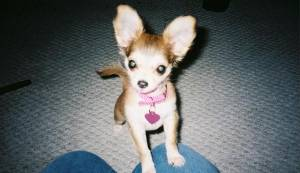

In [35]:
for r in rows:
    image_bytes = r["image"]
    image_stream = io.BytesIO(image_bytes)
    img = Image.open(image_stream).convert("RGB")
    display(img)
    break

# Blip captioning

## load blip image captioning library

In [36]:
%%time
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load the processor and model (using the base model variant)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CPU times: user 577 ms, sys: 3.08 s, total: 3.66 s
Wall time: 5.92 s


def generate_caption(image):
    # Load the processor and model (using the base model variant)
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Open an image using PIL
    raw_image = image.convert("RGB")

    # Preprocess the image
    inputs = processor([raw_image], return_tensors="pt")

    # If using a GPU with 12GB VRAM, move model and inputs to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate caption (you can adjust generation parameters as needed)
    output_ids = model.generate(**inputs, max_length=50)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)

    return caption

## optimized captions as stateful udf

In [37]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import pyarrow as pa

@udf(cuda=True)
class GenCaption:
    def __init__(self):
        self.is_loaded=False

    def setup(self):
        # Load the processor and model (using the base model variant)
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        self.is_loaded=True
        # If using a GPU with 12GB VRAM, move model and inputs to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.is_loaded = True


    def __call__(self, image:bytes) -> str:
        try:
            import geneva

            if not self.is_loaded:
                self.setup()

            # load images and prepare for inputs
            image_stream = io.BytesIO(image)
            raw_image = Image.open(image_stream).convert("RGB")

            # Preprocess the image
            inputs = self.processor([raw_image], return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Generate caption (you can adjust generation parameters as needed)
            output_ids = self.model.generate(**inputs, max_length=50)
            caption = self.processor.decode(output_ids[0], skip_special_tokens=True)
            return caption

        except:
            raise ValueException("problem in UDF") from e




In [38]:
try:
    tbl.drop_columns(["caption_blip_v2"])
except:
    pass

tbl.add_columns({"caption_blip_v2": GenCaption()})
tbl.to_pandas()

2025-08-19 20:14:00 INFO Adding column: udf={'caption_blip_v2': UDF(func=<__main__.GenCaption object at 0x7f14fc92ba90>, name='GenCaption', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='db2b91ecdd80c4951b5cd007c58195d0', checkpoint_key='GenCaption:db2b91ecdd80c4951b5cd007c58195d0', field_metadata={})}


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",None
...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",None


In [39]:
%%time
# And backfill to get captions if we have a gpu
fut = tbl.backfill_async("caption_blip_v2", commit_granularity=2)


CPU times: user 99.5 ms, sys: 18.9 ms, total: 118 ms
Wall time: 1.22 s


In [40]:
%%time
i=0
while not fut.done(timeout=5):
    tbl.checkout_latest()
    try:
        done_rows = tbl.search().where("caption_blip_v2 is not null").to_arrow()    
        print(f"committed {len(done_rows)} rows, currently at version {tbl.version}")
    except Exception as e:
        print(e)

    if i < 1:
        # first partial commit landed
        display(tbl.to_pandas())
    i = i + 1
        
tbl.checkout_latest()
done_rows = tbl.search().where("caption_blip_v2 is not null").to_arrow()    
print(f"committed {len(done_rows)} rows, currently at version {tbl.version}")
tbl.to_pandas()

Must pass schema, or at least one RecordBatch


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",None
...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",None


Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - caption_blip_v2] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - caption_blip_v2] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - caption_blip_v2] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
Must pass schema, or at least one RecordBatch
committed 50 rows, currently at version 46
committed 100 rows, currently at version 47
committed 100 rows, currently at version 47
committed 100 rows, currently at version 47
committed 150 rows, currently at version 48
committed 200 rows, currently at version 49
committed 250 rows, currently at version 50
committed 300 rows, currently at version 51
committed 450 rows, currently at version 54
committed 500 rows, currently at version 56
CPU times: user 7.17 s, sys: 3.58 s, total: 10.7 s
Wall time: 2min 27s


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow
...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill


## unoptimized udf

In [41]:
import torch
import pyarrow as pa

@udf(version="blip", memory=16 * 1024**3, num_cpus=4, cuda=True)
def caption_udf(image:bytes) -> str:
    try:
        import geneva

        # load images and prepare for inputs
        image_stream = io.BytesIO(image)
        pil_image = Image.open(image_stream).convert("RGB")

        answer = generate_caption(pil_image)
        return answer
    except:
        raise ValueException("problem in UDF") from e

In [42]:
try:
    tbl.drop_columns(["caption_blip_slow"])
except:
    pass

tbl.add_columns({"caption_blip_slow": caption_udf})
tbl.to_pandas()

2025-08-19 20:16:31 INFO Adding column: udf={'caption_blip_slow': UDF(func=<function caption_udf at 0x7f14fc924f70>, name='caption_udf', cuda=True, num_cpus=4.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='blip', checkpoint_key='caption_udf:blip', field_metadata={})}


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None
...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None


In [43]:
%%time
# And backfill to get captions if we have a gpu
fut = tbl.backfill_async("caption_blip_slow", commit_granularity=2)

CPU times: user 71.4 ms, sys: 44.2 ms, total: 116 ms
Wall time: 1.13 s


In [44]:
%%time
i=0
while not fut.done(timeout=5):
    tbl.checkout_latest()
    try:
        done_rows = tbl.search().where("caption_blip_slow is not null").to_arrow()    
        print(f"committed {len(done_rows)} rows, currently at version {tbl.version}")
    except Exception as e:
        print(e)

    if i < 1:
        # first partial commit landed
        display(tbl.to_pandas())
    i = i + 1
        
tbl.checkout_latest()
done_rows = tbl.search().where("caption_blip_slow is not null").to_arrow()    
print(f"committed {len(done_rows)} rows, currently at version {tbl.version}")
tbl.to_pandas()

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - caption_blip_slow] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - caption_blip_slow] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - caption_blip_slow] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

ValueError: Must pass schema, or at least one RecordBatch

# History

In [45]:
db.table_names()

['geneva_jobs', 'images']

In [46]:
db._history.jobs_table.to_pandas()

,table_name,column_name,job_id,job_type,object_ref,status,launched_at,completed_at,config
0,images,file_size,3a8ee797-3f4d-4201-b4d8-310b95f61e63,BACKFILL,gAWVUQAAAAAAAACMFnJheS51dGlsLmNsaWVudC5jb21tb2...,DONE,2025-08-19 20:06:00.121149,2025-08-19 20:11:32.622473,"{""where"": null, ""input_columns"": null, ""intra_..."
1,images,dimensions,dd5af934-6f3f-40da-9db1-44004fdee48e,BACKFILL,gAWVUQAAAAAAAACMFnJheS51dGlsLmNsaWVudC5jb21tb2...,DONE,2025-08-19 20:11:35.864532,2025-08-19 20:12:11.663212,"{""where"": null, ""input_columns"": null, ""intra_..."
2,images,embedding,b4745116-82c4-44e1-bf1c-ee2ae4ce5fbb,BACKFILL,gAWVUQAAAAAAAACMFnJheS51dGlsLmNsaWVudC5jb21tb2...,DONE,2025-08-19 20:12:21.947930,2025-08-19 20:13:39.902376,"{""where"": null, ""input_columns"": null}"
3,images,caption_blip_v2,0660c811-ae1a-4c69-85ea-6988aae5773d,BACKFILL,gAWVUQAAAAAAAACMFnJheS51dGlsLmNsaWVudC5jb21tb2...,DONE,2025-08-19 20:14:02.758306,2025-08-19 20:16:16.250750,"{""where"": null, ""input_columns"": null}"
4,images,caption_blip_slow,e7376b8f-45d0-4162-9691-54d7c4f6fe94,BACKFILL,gAWVUQAAAAAAAACMFnJheS51dGlsLmNsaWVudC5jb21tb2...,FAILED,2025-08-19 20:16:33.855792,NaT,"{""where"": null, ""input_columns"": null}"


# Concurrently executing jobs (0.1.36+)

In [47]:
tbl.checkout_latest()
tbl.to_pandas()

,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None
...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None


In [48]:
try:
    tbl.drop_columns(["file_size_async", "dimensions_async", "caption_blip_async", "embedding_async"])
except:
    pass
tbl.add_columns({"file_size_async":file_size, "dimensions_async":dimensions, "caption_blip_async": GenCaption(),  "embedding_async": GenEmbeddings()})
tbl.to_pandas()

2025-08-19 20:16:45 INFO Adding column: udf={'file_size_async': UDF(func=<function file_size at 0x7f152840be20>, name='file_size', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(int64), version='6918aa2663947a6399ad87e52b3c9b58', checkpoint_key='file_size:6918aa2663947a6399ad87e52b3c9b58', field_metadata={})}
2025-08-19 20:16:45 INFO Adding column: udf={'dimensions_async': UDF(func=<function dimensions at 0x7f1512cbb880>, name='dimensions', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=StructType(struct<width: int32, height: int32>), version='e64112b36c08fb6bde12cdf7784c0c5d', checkpoint_key='dimensions:e64112b36c08fb6bde12cdf7784c0c5d', field_metadata={})}
2025-08-19 20:16:46 INFO Adding column: udf={'caption_blip_async': UDF(func=<__main__.GenCaption object at 0x7f14fc9288b0>, name='GenCaption', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=Dat

,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,NaN,None,None,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,NaN,None,None,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,NaN,None,None,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,NaN,None,None,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,NaN,None,None,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,NaN,None,None,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,NaN,None,None,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,NaN,None,None,None


In [49]:
tbl.schema

image: binary
label: int64
image_id: string
label_cat_dog: int64
file_size: int64
  -- field metadata --
  virtual_column.platform.system: 'Linux'
  virtual_column.udf_inputs: '["image"]'
  virtual_column.udf_backend: 'DockerUDFSpecV1'
  virtual_column.platform.arch: 'x86_64'
  virtual_column: 'true'
  virtual_column.platform.python_version: '3.10.16'
  virtual_column.udf_name: 'file_size'
  virtual_column.udf: '_udfs/11014b402e4fd9ff5016fbc9c3384eeeaefdc282ae67' + 20
dimensions: struct<width: int32, height: int32>
  child 0, width: int32
  child 1, height: int32
  -- field metadata --
  virtual_column.platform.python_version: '3.10.16'
  virtual_column.platform.arch: 'x86_64'
  virtual_column.udf_name: 'dimensions'
  virtual_column.udf_inputs: '["image"]'
  virtual_column.platform.system: 'Linux'
  virtual_column.udf: '_udfs/93a314c04a5b057365eba1d798061943ee957313d97c' + 20
  virtual_column.udf_backend: 'DockerUDFSpecV1'
  virtual_column: 'true'
embedding: fixed_size_list<item: float

In [50]:
%%time
import time as timelib
fut1 = tbl.backfill_async("file_size_async")
fut2 = tbl.backfill_async("dimensions_async")
fut3 = tbl.backfill_async("caption_blip_async")
fut4 = tbl.backfill_async("embedding_async")

CPU times: user 374 ms, sys: 115 ms, total: 490 ms
Wall time: 4.94 s


In [51]:
%%time
while not fut1.done(timeout=10):
    print("waiting for jobs to complete...")
tbl.checkout_latest()
tbl.to_pandas()

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - file_size_async] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - file_size_async] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - file_size_async] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
CPU times: user 1.06 s, sys: 823 ms, total: 1.88 s
Wall time: 53.9 s


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,None,None,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,None,None,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,None,None,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,None,None,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,None,None,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,None,None,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,None,None,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,None,None,None


In [52]:
%%time
while not fut2.done(timeout=10):
    print("waiting for job to complete...")
tbl.checkout_latest()
tbl.to_pandas()

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - dimensions_async] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - dimensions_async] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - dimensions_async] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 624 ms, sys: 616 ms, total: 1.24 s
Wall time: 9.53 s


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",None,None
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",None,None
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",None,None
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",None,None
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",None,None
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",None,None
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",None,None
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",None,None


In [53]:
%%time
while not fut3.done(timeout=10):
    print("waiting for jobs to complete...")
tbl.checkout_latest()
tbl.to_pandas()

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - caption_blip_async] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - caption_blip_async] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - caption_blip_async] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
waiting for jobs to complete...
CPU times: user 1.38 s, sys: 688 ms, total: 2.07 s
Wall time: 1min 10s


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",a fluffy white cat,"[0.007883147, 0.086083375, -0.14770496, -0.049..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",a white dog playing with a ball,"[-0.014590063, 0.052585006, -0.109453894, 0.00..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.016874319, 0.061028533, -0.098882824, -0.0..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.022896366, 0.085231416, -0.085755095, -0.0..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",a dog standing in the snow,"[-0.036996376, 0.06692374, -0.094361484, 0.034..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",a dog with a pink tongue,"[0.031918347, 0.089701705, -0.0720305, -0.0301..."
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",a pug dog with a tongue sticking out,"[-0.02544412, 0.116593145, -0.04787898, -0.028..."
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",a cat with green eyes,"[0.03244286, 0.117892295, -0.07319675, -0.0169..."
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",a brown bear sitting on a hill,"[-0.030343307, -0.016256193, -0.12843883, 0.04..."


In [54]:
%%time
while not fut4.done(timeout=10):
    print("waiting for jobs to complete...")
tbl.checkout_latest()
tbl.to_pandas()

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - embedding_async] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - embedding_async] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - embedding_async] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 540 ms, sys: 464 ms, total: 1 s
Wall time: 857 ms


,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",a fluffy white cat,"[0.007883147, 0.086083375, -0.14770496, -0.049..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",a white dog playing with a ball,"[-0.014590063, 0.052585006, -0.109453894, 0.00..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.016874319, 0.061028533, -0.098882824, -0.0..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.022896366, 0.085231416, -0.085755095, -0.0..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",a dog standing in the snow,"[-0.036996376, 0.06692374, -0.094361484, 0.034..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",a dog with a pink tongue,"[0.031918347, 0.089701705, -0.0720305, -0.0301..."
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",a pug dog with a tongue sticking out,"[-0.02544412, 0.116593145, -0.04787898, -0.028..."
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",a cat with green eyes,"[0.03244286, 0.117892295, -0.07319675, -0.0169..."
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",a brown bear sitting on a hill,"[-0.030343307, -0.016256193, -0.12843883, 0.04..."


In [55]:
tbl.to_pandas()

,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",a fluffy white cat,"[0.007883147, 0.086083375, -0.14770496, -0.049..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",a white dog playing with a ball,"[-0.014590063, 0.052585006, -0.109453894, 0.00..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.016874319, 0.061028533, -0.098882824, -0.0..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.022896366, 0.085231416, -0.085755095, -0.0..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",a dog standing in the snow,"[-0.036996376, 0.06692374, -0.094361484, 0.034..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",a dog with a pink tongue,"[0.031918347, 0.089701705, -0.0720305, -0.0301..."
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",a pug dog with a tongue sticking out,"[-0.02544412, 0.116593145, -0.04787898, -0.028..."
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",a cat with green eyes,"[0.03244286, 0.117892295, -0.07319675, -0.0169..."
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",a brown bear sitting on a hill,"[-0.030343307, -0.016256193, -0.12843883, 0.04..."


# Use Blobs

In [56]:
@udf(data_type=pa.large_binary(), field_metadata={"lance-encoding:blob": "true"})
def to_blob(image:bytes) -> bytes:
    return image

In [57]:
try:
    tbl.drop_columns(["image_blob"])
except:
    pass

tbl.add_columns( { "image_blob": to_blob })

2025-08-19 20:19:09 INFO Adding column: udf={'image_blob': UDF(func=<function to_blob at 0x7f14b7d96950>, name='to_blob', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(large_binary), version='8679eba89ce74543adc892b6c744b937', checkpoint_key='to_blob:8679eba89ce74543adc892b6c744b937', field_metadata={'lance-encoding:blob': 'true'})}


In [58]:
tbl.backfill("image_blob")

Cluster nodes provisioned: |           0 [00:00]

Workers scheduled: |           0 [00:00]

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - image_blob] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - image_blob] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - image_blob] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

'1616e353-80d0-47ab-b38c-599c45f44a42'

In [59]:
tbl.to_pandas()

,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async,image_blob
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",a fluffy white cat,"[0.007883147, 0.086083375, -0.14770496, -0.049...","{'position': 0, 'size': 342408}"
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",a white dog playing with a ball,"[-0.014590063, 0.052585006, -0.109453894, 0.00...","{'position': 342464, 'size': 335902}"
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.016874319, 0.061028533, -0.098882824, -0.0...","{'position': 678400, 'size': 424497}"
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.022896366, 0.085231416, -0.085755095, -0.0...","{'position': 1102912, 'size': 505457}"
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",a dog standing in the snow,"[-0.036996376, 0.06692374, -0.094361484, 0.034...","{'position': 1608384, 'size': 235709}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",a dog with a pink tongue,"[0.031918347, 0.089701705, -0.0720305, -0.0301...","{'position': 5746048, 'size': 303150}"
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",a pug dog with a tongue sticking out,"[-0.02544412, 0.116593145, -0.04787898, -0.028...","{'position': 6049216, 'size': 396962}"
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",a cat with green eyes,"[0.03244286, 0.117892295, -0.07319675, -0.0169...","{'position': 6446208, 'size': 220305}"
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",a brown bear sitting on a hill,"[-0.030343307, -0.016256193, -0.12843883, 0.04...","{'position': 6666560, 'size': 440025}"


In [60]:
from lance.blob import BlobFile
@udf
def blob_file_size(image_blob:BlobFile) -> int:
    return len(image_blob.read())

In [61]:
try:
    tbl.drop_columns(["len_image_blob"])
except:
    pass

tbl.add_columns( { "len_image_blob": blob_file_size })

2025-08-19 20:19:46 INFO Adding column: udf={'len_image_blob': UDF(func=<function blob_file_size at 0x7f14b7d943a0>, name='blob_file_size', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image_blob'], data_type=DataType(int64), version='81130e29966aa115de455d0479c622fc', checkpoint_key='blob_file_size:81130e29966aa115de455d0479c622fc', field_metadata={})}


In [62]:
import time as timelib
timelib.sleep(5)

In [63]:
tbl.backfill("len_image_blob", where="0=0")
tbl.to_pandas()

Cluster nodes provisioned: |           0 [00:00]

Workers scheduled: |           0 [00:00]

Workers started:   0%|          | 0/8 [00:00<?, ?it/s]

[images - len_image_blob] Rows checkpointed:   0%|          | 0/500 [00:00<?, ?it/s]

[images - len_image_blob] Rows ready for commit:   0%|          | 0/500 [00:00<?, ?it/s]

[images - len_image_blob] Rows committed:   0%|          | 0/500 [00:00<?, ?it/s]

,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async,image_blob,len_image_blob
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",a fluffy white cat,"[0.007883147, 0.086083375, -0.14770496, -0.049...","{'position': 0, 'size': 342408}",342408
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",a white dog playing with a ball,"[-0.014590063, 0.052585006, -0.109453894, 0.00...","{'position': 342464, 'size': 335902}",335902
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.016874319, 0.061028533, -0.098882824, -0.0...","{'position': 678400, 'size': 424497}",424497
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.022896366, 0.085231416, -0.085755095, -0.0...","{'position': 1102912, 'size': 505457}",505457
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",a dog standing in the snow,"[-0.036996376, 0.06692374, -0.094361484, 0.034...","{'position': 1608384, 'size': 235709}",235709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",a dog with a pink tongue,"[0.031918347, 0.089701705, -0.0720305, -0.0301...","{'position': 5746048, 'size': 303150}",303150
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",a pug dog with a tongue sticking out,"[-0.02544412, 0.116593145, -0.04787898, -0.028...","{'position': 6049216, 'size': 396962}",396962
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",a cat with green eyes,"[0.03244286, 0.117892295, -0.07319675, -0.0169...","{'position': 6446208, 'size': 220305}",220305
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",a brown bear sitting on a hill,"[-0.030343307, -0.016256193, -0.12843883, 0.04...","{'position': 6666560, 'size': 440025}",440025


In [64]:
tbl.to_pandas()

,image,label,image_id,label_cat_dog,file_size,dimensions,embedding,caption_blip_v2,caption_blip_slow,file_size_async,dimensions_async,caption_blip_async,embedding_async,image_blob,len_image_blob
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,20,Maine_Coon_204,0,342408,"{'width': 389, 'height': 500}","[0.007883274, 0.086084016, -0.1477047, -0.0490...",a fluffy white cat,None,342408,"{'width': 389, 'height': 500}",a fluffy white cat,"[0.007883147, 0.086083375, -0.14770496, -0.049...","{'position': 0, 'size': 342408}",342408
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1,american_bulldog_138,1,335902,"{'width': 333, 'height': 500}","[-0.014589928, 0.052585304, -0.109454, 0.00707...",a white dog playing with a ball,None,335902,"{'width': 333, 'height': 500}",a white dog playing with a ball,"[-0.014590063, 0.052585006, -0.109453894, 0.00...","{'position': 342464, 'size': 335902}",335902
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,18,keeshond_112,1,424497,"{'width': 500, 'height': 375}","[-0.016874198, 0.06102884, -0.098882556, -0.02...",a dog laying in the grass,None,424497,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.016874319, 0.061028533, -0.098882824, -0.0...","{'position': 678400, 'size': 424497}",424497
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,16,havanese_157,1,505457,"{'width': 500, 'height': 375}","[-0.022896344, 0.08523144, -0.08575478, -0.014...",a dog laying in the grass,None,505457,"{'width': 500, 'height': 375}",a dog laying in the grass,"[-0.022896366, 0.085231416, -0.085755095, -0.0...","{'position': 1102912, 'size': 505457}",505457
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,14,german_shorthaired_132,1,235709,"{'width': 500, 'height': 333}","[-0.036996305, 0.06692373, -0.09436133, 0.0349...",a dog standing in the snow,None,235709,"{'width': 500, 'height': 333}",a dog standing in the snow,"[-0.036996376, 0.06692374, -0.094361484, 0.034...","{'position': 1608384, 'size': 235709}",235709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,31,shiba_inu_156,1,303150,"{'width': 333, 'height': 500}","[0.031918347, 0.089701705, -0.0720305, -0.0301...",a dog with a pink tongue,None,303150,"{'width': 333, 'height': 500}",a dog with a pink tongue,"[0.031918347, 0.089701705, -0.0720305, -0.0301...","{'position': 5746048, 'size': 303150}",303150
496,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,25,pug_17,1,396962,"{'width': 500, 'height': 375}","[-0.02544412, 0.116593145, -0.04787898, -0.028...",a pug dog with a tongue sticking out,None,396962,"{'width': 500, 'height': 375}",a pug dog with a tongue sticking out,"[-0.02544412, 0.116593145, -0.04787898, -0.028...","{'position': 6049216, 'size': 396962}",396962
497,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,27,Russian_Blue_182,0,220305,"{'width': 500, 'height': 335}","[0.03244286, 0.117892295, -0.07319675, -0.0169...",a cat with green eyes,None,220305,"{'width': 500, 'height': 335}",a cat with green eyes,"[0.03244286, 0.117892295, -0.07319675, -0.0169...","{'position': 6446208, 'size': 220305}",220305
498,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,22,newfoundland_179,1,440025,"{'width': 500, 'height': 333}","[-0.030343307, -0.016256193, -0.12843883, 0.04...",a brown bear sitting on a hill,None,440025,"{'width': 500, 'height': 333}",a brown bear sitting on a hill,"[-0.030343307, -0.016256193, -0.12843883, 0.04...","{'position': 6666560, 'size': 440025}",440025


# shutdown the cluster

In [65]:
type(raycluster)

contextlib._GeneratorContextManager

In [66]:
raycluster.__exit__(None, None, None)

2025-08-19 20:20:30 WARNING Ray was not initialized


False

In [67]:
# 2nd attempt does nothing
raycluster.__exit__(None, None, None)


False

In [68]:
ray.shutdown()